Table of contents
1. [Precinct Shapefile](#shapefile)
2. [Election Results](#electionresults)
3. [Joining Election Results to Precinct Shapefile](#joining)
4. [Comparison to VEST](#comparison)

In [1]:
import numpy as np
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt

<a name="shapefile"></a>


# Precinct Shapefile

## VEST's Documentation File

Election results from Idaho Secretary of State (https://sos.idaho.gov/elections-division/election-results/). Absentee votes were reported countywide or by legislative district for Adams, Bannock, Blaine, Boise, Bonneville, Clearwater, Custer, Elmore, Franklin, Fremont, Gem, Gooding, Idaho, Jefferson, Jerome, Kootenai, Latah, Lemhi, Lewis, Madison, Minidoka, Nez Perce, Owyhee, Shoshone, Teton, Twin Falls, Valley. These were distributed by candidate to precincts based on their share of the precinct-level vote for the given reporting unit.

Precinct shapefiles from the U.S. Census Bureau's 2020 Redistricting Data Program Phase 2 release, except the following counties used shapefiles sourced from the respective county governments instead: Ada, Adams, Bannock, Bingham, Boise, Bonner, Cassia, Clearwater, Custer, Fremont, Jefferson, Kootenai, Latah, Lemhi, Lewis, Madison, Minidoka, Nez Perce, Oneida, Power, Twin Falls, Valley.

County borders in all county-sourced shapefiles were aligned to the U.S Census Bureau's boundaries. The following additional modifications were made to match the 2018 precinct boundaries.

Ada: Merge 1817/1818
Bear Lake: Adjust most precincts to match county maps and voter file
Benewah: Boundaries revised countywide to match legal description
Bonner: Extend precincts over water and align with legal description
Boundary: Merge BF/Kootenai
Butte: Split Arco 1/Moore along USGS watershed line; Adjust Arco 1/2
Camas: Precinct numbers reversed based on county map
Cassia: Merge Burley 1/7
Clark: Adjust Precinct 1/2, 1/3
Elmore: Adjust Mountain Home 4/Hammett
Franklin: Split Cleveland/Mound Valley
Gem: Adjust Lincoln/Emerson, Hanna/West Emmett
Gooding: Align boundaries with PLSS grid and city limits
Idaho: Adjust Clearwater/Stites
Jerome: Split Canyonside/Rimrock
Latah: Merge 29/39; Adjust 19/29
Teton: Adjust precinct 6 to match Victor city limits
Washington: Align Weiser precincts with city limits
```
G18GOVRLIT - Brad Little (Republican Party)
G18GOVDJOR - Paulette Jordan (Democratic Party)
G18GOVLBOE - Bev "Angel" Boeck (Libertarian Party)
G18GOVCBAY - Walter L. Bayes (Constitution Party)
G18GOVOWRI - Write-in Votes

G18LTGRMCG - Janice McGeachin (Republican Party)
G18LTGDCOL - Kristin Collum (Democratic Party)

G18SOSRDEN - Lawerence E. Denney (Republican Party)
G18SOSDHUM - Jill Humble (Democratic Party)

G18CONRWOO - Brandon D. Woolf (Republican Party)

G18TRERELL - Julie A. Ellsworth (Republican Party)

G18ATGRWAS - Lawrence Wasden (Republican Party)
G18ATGDBIS - Bruce S. Bistline (Democratic Party)

G18SPIRYBA - Sherri Ybarra (Republican Party)
G18SPIDWIL - Cindy Wilson (Democratic Party)
```

## Load VEST's Final File

In [2]:
vest_shp = gp.read_file("./raw-from-source/VEST/id_2018/id_2018.shp")

In [3]:
vest_shp.shape

(933, 20)

In [4]:
vest_shp.head(1)

,STATEFP,COUNTYFP,VTDST,NAME,G18GOVRLIT,G18GOVDJOR,G18GOVLBOE,G18GOVCBAY,G18GOVOWRI,G18LTGRMCG,G18LTGDCOL,G18SOSRDEN,G18SOSDHUM,G18CONRWOO,G18TRERELL,G18ATGRWAS,G18ATGDBIS,G18SPIRYBA,G18SPIDWIL,geometry
0,16,013,132601,16 Yale,8,0,0,0,0,7,0,7,0,7,7,8,0,5,0,"POLYGON Z ((-113.17891 42.75202 0.00000, -113...."


<AxesSubplot:>

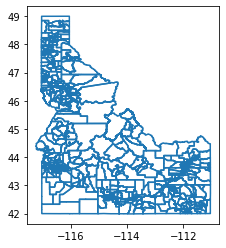

In [5]:
vest_shp.boundary.plot()

## Load Source Precinct File

### Create a FIPS code dictionary

In [6]:
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Idaho"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)
fips_file["unique_ID"] =  "16" + fips_file["FIPS County"]
fips_codes = fips_file["unique_ID"].tolist()
fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

### Precinct Shapefiles from the U.S. Census Bureau's Phase 2 Release

In [7]:
#Combine all the data from separate files into one
li = []
for i in fips_codes:
    ref = "./raw-from-source/Census/partnership_shapefiles_19v2_"
    file_ref = ref+i+"/PVS_19_v2_vtd_"+i+".shp"
    file_prev = gp.read_file(file_ref)
    #print(file_prev.shape)
    li.append(file_prev)
global shapefiles_census
shapefiles_census = pd.concat(li, axis=0, ignore_index=True)

In [8]:
shapefiles_census.shape

(932, 16)

In [9]:
shapefiles_census.head(1)

,STATEFP,COUNTYFP,VTDST,NAMELSAD,VTDI,LSAD,CHNG_TYPE,ORIG_NAME,ORIG_CODE,RELATE,NAME,VINTAGE,FUNCSTAT,JUSTIFY,MTFCC,geometry
0,16,001,011401,1401,A,00,None,None,None,None,1401,90,N,None,G5240,"POLYGON Z ((-116.51274 43.73324 0.00000, -116...."


<AxesSubplot:>

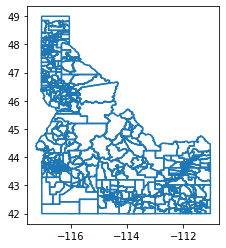

In [10]:
shapefiles_census.boundary.plot()

See the number of precincts in each county between the Census Phase 2 Release and the VEST file where the number of precincts is not the same. 

In [18]:
shapefiles_census.groupby('COUNTYFP')['VTDST'].count().compare(vest_shp.groupby('COUNTYFP')['VTDST'].count() ) #, keep_shape = True, keep_equal = True)

,self,other
COUNTYFP,,
001,145.0,150.0
005,58.0,52.0
007,14.0,15.0
017,34.0,32.0
021,7.0,6.0
031,25.0,24.0
041,17.0,18.0
043,14.0,13.0
047,7.0,6.0


In [60]:
fips_dict

{'Ada': '001',
 'Adams': '003',
 'Bannock': '005',
 'Bear Lake': '007',
 'Benewah': '009',
 'Bingham': '011',
 'Blaine': '013',
 'Boise': '015',
 'Bonner': '017',
 'Bonneville': '019',
 'Boundary': '021',
 'Butte': '023',
 'Camas': '025',
 'Canyon': '027',
 'Caribou': '029',
 'Cassia': '031',
 'Clark': '033',
 'Clearwater': '035',
 'Custer': '037',
 'Elmore': '039',
 'Franklin': '041',
 'Fremont': '043',
 'Gem': '045',
 'Gooding': '047',
 'Idaho': '049',
 'Jefferson': '051',
 'Jerome': '053',
 'Kootenai': '055',
 'Latah': '057',
 'Lemhi': '059',
 'Lewis': '061',
 'Lincoln': '063',
 'Madison': '065',
 'Minidoka': '067',
 'Nez Perce': '069',
 'Oneida': '071',
 'Owyhee': '073',
 'Payette': '075',
 'Power': '077',
 'Shoshone': '079',
 'Teton': '081',
 'Twin Falls': '083',
 'Valley': '085',
 'Washington': '087'}

# Election Results

## Load in Election Results

Downloaded SOS Election Results using the same file linked by VEST, and cleaned them in Excel. Results do not require pivoting. 

In [25]:
election_results = pd.read_csv('./raw-from-source/SOS/18gen_stwd_pct_clean.csv')

In [26]:
election_results.head()

,County,Precinct,G18GOVCBAY,G18GOVLBOE,G18GOVDJOR,G18GOVRLIT,G18GOVOWRI,G18LTGDCOL,G18LTGRMCG,G18SOSRDEN,G18SOSDHUM,G18CONRWOO,G18TRERELL,G18ATGDBIS,G18ATGRWAS,G18SPIDWIL,G18SPIRYBA
0,ADA,1401,9,7,295,817,0,315,803,830,280,928,929,231,867,411,704
1,ADA,1402,5,7,356,1069,0,389,1037,1066,346,1184,1180,312,1101,512,905
2,ADA,1403,10,19,461,1067,0,499,1044,1081,445,1212,1212,376,1138,602,912
3,ADA,1404,14,15,329,944,0,333,944,976,301,1121,1123,297,975,464,812
4,ADA,1405,13,10,430,1015,0,433,1015,1043,396,1217,1223,354,1070,577,844


## Compare Election Result Totals

In [28]:
races = [x for x in vest_shp.columns if 'G18' in x]
races

['G18GOVRLIT',
 'G18GOVDJOR',
 'G18GOVLBOE',
 'G18GOVCBAY',
 'G18GOVOWRI',
 'G18LTGRMCG',
 'G18LTGDCOL',
 'G18SOSRDEN',
 'G18SOSDHUM',
 'G18CONRWOO',
 'G18TRERELL',
 'G18ATGRWAS',
 'G18ATGDBIS',
 'G18SPIRYBA',
 'G18SPIDWIL']

### Compare Vote Totals

In [29]:
sum_var_1 = 0
sum_var_2 = 0
for i in races:
    sum_var_1 += np.sum(vest_shp[i])
    sum_var_2 += np.sum(election_results[i])
print(sum_var_1)
print(sum_var_2)

3907437
3907437


### Compare Race Totals

In [31]:
for race in races:
    diff_val = sum(vest_shp[race])-sum(election_results[race])
    if diff_val != 0:
        print(race+": "+str(diff_val))
    else:
        print(race+": EQUAL")

G18GOVRLIT: EQUAL
G18GOVDJOR: EQUAL
G18GOVLBOE: EQUAL
G18GOVCBAY: EQUAL
G18GOVOWRI: EQUAL
G18LTGRMCG: EQUAL
G18LTGDCOL: EQUAL
G18SOSRDEN: EQUAL
G18SOSDHUM: EQUAL
G18CONRWOO: EQUAL
G18TRERELL: EQUAL
G18ATGRWAS: EQUAL
G18ATGDBIS: EQUAL
G18SPIRYBA: EQUAL
G18SPIDWIL: EQUAL


### More Detailed Vote Comparisons

In [37]:
vest_shp["join_col"]=vest_shp['COUNTYFP']+vest_shp['NAME']
election_results["join_col"]=election_results["County"]+election_results["Precinct"]

In [45]:
#Check to make sure that the join_col in both files is unique

print(len(election_results["join_col"]))
print(election_results["join_col"].value_counts().sum())

print(len(vest_shp["join_col"]))
print(vest_shp["join_col"].value_counts().sum())

972
972
933
933


### Add Zero Vote Precincts from VEST's File

In [47]:
vest_shp[vest_shp['G18GOVRLIT'] == 0]

,STATEFP,COUNTYFP,VTDST,NAME,G18GOVRLIT,G18GOVDJOR,G18GOVLBOE,G18GOVCBAY,G18GOVOWRI,G18LTGRMCG,...,G18SOSRDEN,G18SOSDHUM,G18CONRWOO,G18TRERELL,G18ATGRWAS,G18ATGDBIS,G18SPIRYBA,G18SPIDWIL,geometry,join_col
453,16,011,113127,Bonneville 27,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"POLYGON Z ((-111.80360 43.28228 0.00000, -111....",011Bonneville 27


In [48]:
election_results[election_results['G18GOVRLIT'] == 0]

,County,Precinct,G18GOVCBAY,G18GOVLBOE,G18GOVDJOR,G18GOVRLIT,G18GOVOWRI,G18LTGDCOL,G18LTGRMCG,G18SOSRDEN,G18SOSDHUM,G18CONRWOO,G18TRERELL,G18ATGDBIS,G18ATGRWAS,G18SPIDWIL,G18SPIRYBA,join_col
263,BINGHAM,Bonneville 27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,BINGHAMBonneville 27


Doesn't look like there's any zero vote precincts to add. 

### Deal with the countywide votes in the recreated file

#### Make a df with the countywide votes and their totals

In [68]:
#Create a list of the all the different names used for these types of votes
#These were find in comparing the names present in both files
filter_out_list = [x for x in election_results['Precinct'].unique() if 'Absentee' in x or 'ABSENTEE' in x or 'ABS Leg Dist' in x]

In [69]:
#Create a df of just these precincts
to_dole_out = election_results[election_results["Precinct"].isin(filter_out_list)]

In [71]:
#Create a new df with the county-by-county totals of these precincts and reset the index 
to_dole_out_totals = pd.DataFrame(to_dole_out.groupby(["County"]).sum())
to_dole_out_totals.reset_index(inplace=True,drop=False)

#### Filter out the countywide precincts from the original dataframe and get the precinct-level vote totals by county

In [72]:
#Filter out the countywide votes from the dataframe so we can iterate over just the remaining precincts and add votes
filtered_election = election_results[~election_results["Precinct"].isin(filter_out_list)]

#Create a df with the county-by-county sums of precinct-level votes, this will be used in the allocation, clean the index
precinct_specific_totals = pd.DataFrame(filtered_election.groupby(["County"]).sum())
precinct_specific_totals.reset_index(inplace=True,drop=False)
filtered_election.reset_index(inplace=True,drop=True)

#Look at both dfs to get a sense for what they show
print(precinct_specific_totals.head())
print(to_dole_out_totals.head())

      County  G18GOVCBAY  G18GOVLBOE  G18GOVDJOR  G18GOVRLIT  G18GOVOWRI  \
0        ADA        1086        1943       94772       92684          17   
1      ADAMS          14          20         431        1026           0   
2    BANNOCK         257         303        9024       11516           0   
3  BEAR LAKE          39          25         307        1780           0   
4    BENEWAH          39          48        1004        2672           0   

   G18LTGDCOL  G18LTGRMCG  G18SOSRDEN  G18SOSDHUM  G18CONRWOO  G18TRERELL  \
0       99311       88189       95073       90389      131433      131838   
1         410        1045        1090         372        1225        1227   
2        9169       11643       12202        8491       17273       17263   
3         356        1779        1778         355        1998        2004   
4        1012        2653        2692         952        3110        3130   

   G18ATGDBIS  G18ATGRWAS  G18SPIDWIL  G18SPIRYBA  
0       81514      102150   

#### Allocate the countywide votes

In [75]:
to_dole_out['County'].unique()

array(['ADAMS', 'BANNOCK', 'BLAINE', 'BOISE', 'BONNEVILLE', 'BOUNDARY',
       'CLEARWATER', 'CUSTER', 'ELMORE', 'FRANKLIN', 'FREMONT', 'GEM',
       'GOODING', 'IDAHO', 'JEFFERSON', 'JEROME', 'KOOTENAI', 'LATAH',
       'LEMHI', 'LEWIS', 'MADISON', 'MINIDOKA', 'NEZ PERCE', 'OWYHEE',
       'SHOSHONE', 'TETON', 'TWIN FALLS ', 'VALLEY'], dtype=object)

In [79]:
#Create some new columns for each of these races to deal with the allocation
for race in races:
    add_var = race+"_add"
    rem_var = race+"_rem"
    floor_var = race+"_floor"
    filtered_election.loc[:,add_var]=0.0
    filtered_election.loc[:,rem_var]=0.0
    filtered_election.loc[:,floor_var]=0.0

#Iterate over the rows
#Note this function iterates over the dataframe two times so the rounded vote totals match the totals to allocate
for index, row in filtered_election.iterrows():
    #No countywide votes for 510
    if row["County"] in to_dole_out['County'].unique():
        for race in races:
            add_var = race+"_add"
            rem_var = race+"_rem"
            floor_var = race+"_floor"
            #Grab the county
            county_id = row["County"]
            #Get the denominator for the allocation (the precinct vote totals)
            denom = precinct_specific_totals.loc[precinct_specific_totals["County"]==county_id][race]
            #Get one of the numerators, how many countywide votes to allocate
            numer = to_dole_out_totals.loc[to_dole_out_totals["County"]==county_id][race]
            #Get the vote totals for this race in this precinct
            val = filtered_election.at[index,race]
            #Get the vote share, the precincts % of total precinct votes in the county times votes to allocate
            vote_share = (float(val)/float(denom))*float(numer)
            filtered_election.at[index,add_var] = vote_share
            #Take the decimal remainder of the allocation
            filtered_election.at[index,rem_var] = vote_share%1
            #Take the floor of the allocation
            filtered_election.at[index,floor_var] = np.floor(vote_share)

#After the first pass through, get the sums of the races by county            
first_allocation = pd.DataFrame(filtered_election.groupby(["County"]).sum())

#Now we want to iterate county by county to work on rounding
county_list = list(to_dole_out_totals["County"].unique()) 

#Iterate over the counties
for county in county_list:
    for race in races:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
        to_go = int(np.round((int(to_dole_out_totals.loc[to_dole_out_totals["County"]==county][race])-first_allocation.loc[first_allocation.index==county,floor_var])))
        #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
        for index in filtered_election.loc[filtered_election["County"]==county][rem_var].nlargest(to_go).index:
            filtered_election.at[index,add_var] = np.ceil(filtered_election.at[index,add_var])

#Iterate over every race again
for race in races:
    add_var = race+"_add"
    #Round every allocation down
    filtered_election.loc[:,add_var]=np.floor(filtered_election.loc[:,add_var])
    #Add every allocation to the total
    filtered_election.loc[:,race]+=filtered_election.loc[:,add_var]

#Filter back down to the original columns
filtered_election = filtered_election[list(election_results.columns)]

ZeroDivisionError: float division by zero

Got this code from Peter's MO 2016 and left off here. 

#### Check the allocation by making sure the vote totals still equal one another

In [ ]:
for race in races:
    diff_val = sum(vest_shp[race])-sum(filtered_election[race])
    if diff_val!=0:
        print(race+": "+str(diff_val))
    else:
        print(race+": EQUAL")